# Fire Image Classification

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# Keras Imports
import tensorflow as tf
import keras
from keras import backend as K
# CNN and MLP architecture
from keras.models import Sequential
from keras.layers import (
    Dense,
    Conv2D,
    MaxPooling2D,
    UpSampling2D,
    Dropout,
    Flatten,
    BatchNormalization
)
from keras.models import Model
from keras.optimizers import SGD
from keras.initializers import RandomNormal
# Keras Callbacks
from keras.callbacks import EarlyStopping, TensorBoard
# Time Training
import time
# Data Splitting
from sklearn.model_selection import train_test_split
# Image Preprocessing
from PIL import Image
from keras.preprocessing.image import img_to_array

Using TensorFlow backend.


## Get the Data

In [2]:
df = pd.read_csv('Fire-Detection-Image-Dataset/fires.csv')

In [3]:
df.head()

,Unnamed: 0,Folder,filename,label
0,0,Normal Images 3,Hot-in-Cleveland-house-at-night-front.jpg,0
1,1,Normal Images 3,hotel-continental-marienbad-room-standard-10.jpg,0
2,2,Normal Images 3,hotel.jpg,0
3,3,Normal Images 3,Hotel_Monterey_La_Soeur_Osaka_standard_twin_be...,0
4,4,Normal Images 3,house off lincoln road night.jpg,0


In [4]:
# define predictor and target sets of data
features = [df.columns[1], df.columns[2]]
target = [df.columns[3]]
X, y = df[features], df[target]
# Store number of class
num_classes = 2

## Split DataFrame Based on Label

In [5]:
# Split df into train and test, based on label
# Credit goes to this Stack Overflow answer for the following:
# https://stackoverflow.com/questions/24147278/how-do-i-create-test-and-train-samples-from-one-dataframe-with-pandas
selector = np.random.rand(len(df)) < 0.75
df_train, df_test = df[selector], df[~selector]
print(f"Number of Training Samples: {len(df_train)}")
print(f"Number of Testing Samples: {len(df_test)}")

Number of Training Samples: 143
Number of Testing Samples: 39


In [6]:
df_train.head()
# df_train['Unnamed: 0'].iloc[:20] -- checking the index for samples in training data

,Unnamed: 0,Folder,filename,label
0,0,Normal Images 3,Hot-in-Cleveland-house-at-night-front.jpg,0
1,1,Normal Images 3,hotel-continental-marienbad-room-standard-10.jpg,0
2,2,Normal Images 3,hotel.jpg,0
3,3,Normal Images 3,Hotel_Monterey_La_Soeur_Osaka_standard_twin_be...,0
4,4,Normal Images 3,house off lincoln road night.jpg,0


## Defining the Optimal Model 

### Build a Generator

For this dataset, we'll increase the efficiency of training by loading in subsections of the dataset to train on at a time, using Python-esque generator in Keras!

In [7]:
def data_gen(df, batch_size):
    """Generate batches of the dataset to train the model on, one subsection at a time.
       Credit goes to Milad Toutounchian for this implementation, originally found at:
       https://github.com/Make-School-Courses/DS-2.2-Deep-Learning/blob/master/Final_Project/image_data_prep.ipynb
    
       Parameters:
       df(DataFrame): larger portion of the datset used for training
       batch_size(int): the number of samples to include in each batch
       
       Returns:
       tuple: input features of the batch, along with corresponding labels
    
    """
    while True:
        # list of images
        x_batch = np.zeros((batch_size, 1024, 1024, 3))
        # list of labels
        y_batch = np.zeros((batch_size, 1))
        # add samples until we reach batch size
        for j in range(len(df) // batch_size):
            batch_index = 0
            for index, image_file, label in zip(df_train['Unnamed: 0'],
                                                df['filename'].values[j*batch_size:(j+1)*batch_size], 
                                                df['label'].values[j*batch_size:(j+1)*batch_size]):
                print(f'index: {index}, image file: {image_file}')
                filepath = f"Fire-Detection-Image-Dataset/{df['Folder'][index]}/{image_file}"
                print(f'File: {filepath}')
                img = Image.open(filepath)
                plt.imshow(img)
                image_red = img.resize((1024, 1024))
                x_batch[batch_index] = img_to_array(image_red)
                y_batch[batch_index] = label
                batch_index += 1
            yield (x_batch, y_batch)

### Finding the Best Architecture

Now we'll find the optimal number of layers and neurons per layer using TensorBoard.

In [8]:
# Helper functions to Reduce Repetition of Adding Layers
def add_conv_layer(model, layer_size, needs_input):
    """Add a Keras convolutional layer to the model, along with MaxPooling.
       Will specify input shape as well if needed.
       
       Parameters:
       model(Model): Neural network in Keras
       layer_size(int): number of neurons to go in layer
       need_input(bool): signals if the convolutional layer needs to specify
                         the dimensions of the input
       
       Returns: None
       
    """
    if needs_input is True:
        # specify input dimension for 1st conv layer
        conv_layer = Conv2D(layer_size,
                            kernel_size=(3, 3),
                            activation='relu',
                            input_shape=(1024, 1024, 3))

    else:
        # otherwise all other convolutional layers don't need it
        conv_layer = Conv2D(layer_size,
                            kernel_size=(3, 3),
                            activation='relu')
    # add Convolutional layer
    model.add(conv_layer)  
    # add MaxPooling layer
    model.add(MaxPooling2D(pool_size=(2, 2)))  # no learning params
    return None
                  
    
def add_dense_layer(model, layer_size, is_output):
    """Add a multi-layer perceptron to the model
       Will specify 'sigmoid' for the final layer.
       
       Parameters:
       model(Model): Neural network in Keras
       layer_size(int): number of neurons to go in layer
       is_output(bool): signals if the MLP is the last layer
       
       Returns: None
       
    """
    # specify activation function
    activation = 'relu' if is_output is False else 'sigmoid'
    # add MLP
    model.add(Dense(layer_size, activation=activation))         
    return None

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



index: 0, image file: house-with-lights-on.jpg
index: 0, image file: Hot-in-Cleveland-house-at-night-front.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Hot-in-Cleveland-house-at-night-front.jpg
index: 1, image file: hotel-continental-marienbad-room-standard-10.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/hotel-continental-marienbad-room-standard-10.jpg
Epoch 1/5
index: 2, image file: hotel.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/hotel.jpg
index: 3, image file: Hotel_Monterey_La_Soeur_Osaka_standard_twin_bedroom_20121102-001.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Hotel_Monterey_La_Soeur_Osaka_standard_twin_bedroom_20121102-001.jpg
index: 4, image file: house off lincoln road night.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/house off lincoln road nig

index: 3, image file: London-Office--tojpeg_1431338424080_x2.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/London-Office--tojpeg_1431338424080_x2.jpg
index: 4, image file: maxresdefault.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/maxresdefault.jpg
index: 7, image file: maxresdefaultvfv.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/maxresdefaultvfv.jpg
index: 8, image file: meda_bia_class_0.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/meda_bia_class_0.jpg
index: 9, image file: Meeting room with people.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Meeting room with people.jpg
index: 10, image file: Meeting room with people2.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Meeting room with people2.jpg
index: 11, image file: meeting.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/meeting.jpg
index: 12, image file: messy-office-space.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/messy-office-space.jpg
index: 14, image fi

FileNotFoundError: [Errno 2] No such file or directory: 'Fire-Detection-Image-Dataset/Normal Images 3/1.jpg'

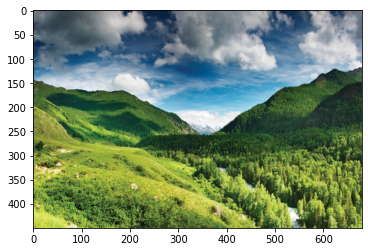

In [9]:
# Choices for the Model Architecture - values arbitrary
dense_layers = [1, 2, 3]
layer_sizes = [32, 64, 128]
conv_layers = [1, 2, 3]

# try different combinations!
# These for loops come from https://youtu.be/lV09_8432VA
for dense_layer in dense_layers:
    for size in layer_sizes:
        for conv in conv_layers:
            # name the combo
            NAME = (
                f'{conv}-conv-{size}-nodes' +
                f'-{dense_layer}-dense_layers' + 
                f'-{int(time.time())}'
            )
        # Instantiate TensorBoard to visualize model performance
        tensorboard = TensorBoard(log_dir=f'./Graph/{NAME}')
        # Instaniate model
        model = Sequential()
        # Add CNN layers
        add_conv_layer(model, size, True)
        for l in range(conv - 1):
            # add convolutional layers that come after the 1st
            add_conv_layer(model, size, False)
        # Flatten the data
        model.add(Flatten())
        # Add MLP Layers
        for l in range(dense_layer - 1):
            add_dense_layer(model, size, False)
        # add final MLP, for output
        add_dense_layer(model, 1, True)
        # Compile Model
        model.compile(loss=keras.losses.binary_crossentropy,
                      optimizer=keras.optimizers.Adadelta(),
                      metrics=['accuracy',
                               tf.keras.metrics.Precision(),
                               tf.keras.metrics.Recall()])
        
        # Train the Model (using a generator!)
        # epoch is 5, batch_size is currently set to 20
        epochs, batch_size = 5, 20
        history = model.fit_generator(generator=data_gen(df_train, batch_size=batch_size),
                            steps_per_epoch=len(df_train['label']) // batch_size,
                            epochs=epochs,
                            validation_data=data_gen(df_test, batch_size=batch_size),
                            validation_steps=len(df_test['label']) // batch_size, 
                            callbacks=[tensorboard])

###  Finding Optimal Hyperparameters

Now, we'll find the optimal values for the hyperparameters using hyperas.

### Summarize the Model

In [5]:
print(model.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               1179776   
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 258       
Total params: 1,198,850
Trainable params: 1,198,850
Non-trainable params: 0
____________________________________________

## Upsample the Minority Class

We need more fire!

## Data Augumentation

Let's add more variation to the dataset now, in order to make the model more robust!

## Model Evaluation

## Final Conclusions